# 02. Data Preprocessing

# I. Team-Members:
- Felix Gaber, 20221385@novaims.unl.pt
- Felix Gayer, 20220320@novaims.unl.pt
- David Halder, 20220632@novaims.unl.pt
- Lukas Stark, 20220626@novaims.unl.pt
- Rita Soares, 20220616@novaims.unl.pt

# II. Link to the Dataset:
https://drive.google.com/drive/folders/1D8Hd49L0OLlSz2oCuuctfCKDcR8HK_c4?usp=share_link

# III. Summary of the notebook:
In this notebook the dataset is getting pre-processed based on the insights of the data exploration. Furthermore, image augmentation steps are visually inspected  and assessed based on their ability to enhance or to diversify the dataset.  

Utilising the function "image_dataset_from_directory" the labeled data is imported, split and resized. A detailed description of the different hyperparameters can be found later in the notebook. The preprocessing steps are then controlled by visually inspecting a random selection of images from the pre-processed batch. Finally, the train/validation split is checked by counting the images per set per class. In summary the pre-processing and the split worked without any problems.

Next, it is assessed that the images need to be scaled, in order for the model to run stable and efficiently. The differences in the scaling of the pictures was assessed via the standard deviation and the mean of the pixel values. It was concluded that scaling is needed, which will be done in the first layer of the convolutional neural network.

Next, nine different image augmentation steps are tested and the images are compared visually. The purpose of this analysis is to get a good understanding of the different image augmentation steps and to identify appropriate augmentation layers that could improve the model. 

Finally, offline augmentation is used to diversify and to increase the  dataset. The augmented pictures are then saved.



Sources: 
1. Keras (2021): Keras documentation: Image data preprocessing. Available online at https://keras.io/api/preprocessing/image/, updated on 12/3/2021, checked on 3/31/2023.

2. Brownlee, Jason: Deep Learning for Computer Vision. Available online at https://machinelearningmastery.com/how-to-evaluate-pixel-scaling-methods-for-image-classification/, checked on 3/31/2023.

3. Shorten, Connor; Khoshgoftaar, Taghi M. (2019): A survey on Image Data Augmentation for Deep Learning. In J Big Data 6 (1), pp. 1–48. DOI: 10.1186/s40537-019-0197-0.

**Mount Personal GDrive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Access**
1. Create shortcut to shared folder '**03 Project**'
2. Create new folder on personal GDrive called '**DeepLearningProject**' and click on 'ADD SHORTCUT'
3. Check if following path is available '**/content/drive/MyDrive/DeepLearningProject/03 Project**'

In [ ]:
%cd '/content/drive/MyDrive/DeepLearningProject/03 Project'

/content/drive/.shortcut-targets-by-id/1_93ad1t8CGrSTc3bgngEEjuCVXLB6eHY/03 Project


---
# 2.1 Import libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

#For offline augmentation
import os
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import random
from skimage import exposure
from PIL import ImageOps
from keras.preprocessing import image
import cv2


---
# 2.2 Importing splitting and resizing the images

As it was concluded in the data exploration, there are multiple (746) image sizes. Thus the images need to be resized, in order to prepare them for the Convolutional Neural Network. To keep the images as large as possible, the images are altered to fit the size **224x224**, which is the smallest image size in the dataset. 


In [ ]:
# Set path to dataset
path = "Data/Tire Textures/training_data"

ds_train, ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path,

    #labels are generated from the directory structure
    labels="inferred",

    #labels - normal and cracked
    label_mode="binary",

    #take the alphanumerical order
    class_names=None,

    #color mode: as we concluded all the pictures are RGB colored
    color_mode="rgb",

    #Setting the image size to the same as our minimum (image.size)
    image_size=(224, 224),

    #Data should be shuffled
    shuffle=True,

    #ensure reproducibility 
    seed=42,

    #We are using a validation split of 0.2
    validation_split = 0.2,

    #size of the batches of data. How many images are processed together in a single forward and backwards pass.
    batch_size=32,

    #Training and validation split is set
    subset="both",

    #interpolation will define how the new pixel values are determinated 
    #bilinear will use the weighted average of the 4 neighbors
    interpolation="bilinear",

    #avoid distortion, risk of loosing information 
    crop_to_aspect_ratio=True)

Found 703 files belonging to 2 classes.
Using 563 files for training.
Using 140 files for validation.


**Explanation of the set preprocessing parameters:**

- **Directory**: path to the directory of the images and to the subdirectory of the labels
- **Labels**: Since our dataset is labeled and the labels are within the directory struture we set the value to "inferred" so that the labels are generated out of the directory
-**Label_mode**: set to "binary" since the classes are  binary (cracked or normal)
-**Class Names**: Set to None, since there is not a list of labels
-**Color Mode**: As concluded earlier all the pictures are RGB-colored, thus the color mode is set to "rgb". This might be changed during the building of the architecture of the handcrafted model.
-**Image Size**: the size the images are resized too. Set to the size of the smallest picture in the dataset.
- **Shuffle**: Set to true, so that the order of the dataset and the train/validation split is randomized.
-  **Seed**: to ensure reproducibility for the shuffling and the transformations a random seed is set
- **Validation Split**: set to 0.2, which means that 20% of the training set is put apart for validation
- **Batch_size**: defines the number of images in one batch. The batch defines how many images are processed together in one single forward and backward pass.
-**Interpolation**: Defines the interpolation method used for resizing the images. Interpolation is a method to estimate pixel values that are not present in an image. Here the "bilinear" method was chosen, which calculates the color of a pixel based on the weighted average of its sourrounding pixels. This method can also be changed during the cration of the handcrafted model to assess its impact in the accuraccy score.
-**Crop_to_aspect_ratio**: this parameter defines if the aspect ratio of the of the original image is preserved or not. Here it was decided to preserve the aspect ratio, so that distortion or stretching of the image is prevented.

[1] See Keras 2021

To ensure that the pre-processing passed without any problems, another visual inspection is conducted of multiple randomly chosen pictures. The size and the rgb channels are also reviewed one more time.

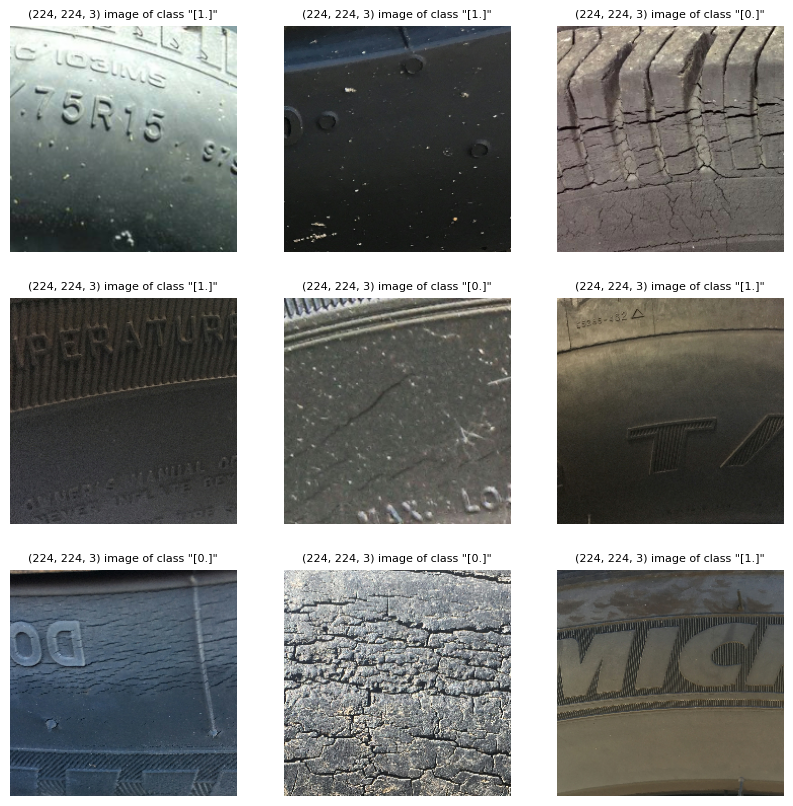

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

It can be concluded that the import/preprocessing steps were all fulfilled without any disruptions or distortions. 

Finally, the class distribution in the train/validation is checked for. To do so, a function was written to count the images within each class for both sets. 

In [ ]:
def class_dist_check(ds_train, ds_val):
  class_names= ds_train.class_names

  # Count the number of images in each class for the training data
  num_images_train = []
  for class_name in class_names:
      num_images = 0
      for images, labels in ds_train:
          num_images += tf.math.count_nonzero(labels == class_names.index(class_name)).numpy()
      num_images_train.append(num_images)

  # Count the number of images in each class for the validation data
  num_images_valid = []
  for class_name in class_names:
      num_images = 0
      for images, labels in ds_val:
          num_images += tf.math.count_nonzero(labels == class_names.index(class_name)).numpy()
      num_images_valid.append(num_images)

  # Print out the results
  print('Training set:')
  for i in range(len(class_names)):
      print(f'{class_names[i]}: {num_images_train[i]}')

  print('\nValidation set:')
  for i in range(len(class_names)):
      print(f'{class_names[i]}: {num_images_valid[i]}')

class_dist_check(ds_train, ds_val)

Training set:
cracked: 263
normal: 300

Validation set:
cracked: 64
normal: 76


In the **training** set there is a split of **47%** cracked tire images and **53%** normal tires.

In the **validation** set there is a split of **46%** cracked tire images and **54%** normal tires.

The distribution across classes is the almost exactly the same for both the validation and the training set and no class is underrepresented. Thus, no action needs to be taken here.

# 2.3 Image Scaling

To use the images in the neural network which will be created they have to be scaled. The raw images cannot be used since the model uses a weighted sum of inputs, which will get too large if the input values (pixels) are not scaled. Thus, in order for the model to run stable and effectively, the weights should be kept small. (See Brownley, 2019)[2]



Three different types of scaling can be considered.
  1. Normalization: Set the pixel values for a range of [0,1]
  2. Centering: Set pixel to have a zero mean. 
  3. Standardization: Set pixel to have a zero mean and unit variance.


To assess the differences in the scaling of the images, the mean and the standard deviation of the pixel values are calculated.

In [ ]:
for images, labels in ds_train:
    batch_mean = tf.math.reduce_mean(images)
    batch_std = tf.math.reduce_std(images)
    print('Mean:', batch_mean)
    print('Std:', batch_std)

Mean: tf.Tensor(110.56139, shape=(), dtype=float32)
Std: tf.Tensor(48.827553, shape=(), dtype=float32)
Mean: tf.Tensor(104.86026, shape=(), dtype=float32)
Std: tf.Tensor(43.390953, shape=(), dtype=float32)
Mean: tf.Tensor(110.94897, shape=(), dtype=float32)
Std: tf.Tensor(48.04848, shape=(), dtype=float32)
Mean: tf.Tensor(108.207245, shape=(), dtype=float32)
Std: tf.Tensor(46.294476, shape=(), dtype=float32)
Mean: tf.Tensor(107.94332, shape=(), dtype=float32)
Std: tf.Tensor(50.225292, shape=(), dtype=float32)
Mean: tf.Tensor(103.365944, shape=(), dtype=float32)
Std: tf.Tensor(51.351337, shape=(), dtype=float32)
Mean: tf.Tensor(109.43439, shape=(), dtype=float32)
Std: tf.Tensor(45.538105, shape=(), dtype=float32)
Mean: tf.Tensor(102.87125, shape=(), dtype=float32)
Std: tf.Tensor(49.072495, shape=(), dtype=float32)
Mean: tf.Tensor(107.667366, shape=(), dtype=float32)
Std: tf.Tensor(52.64246, shape=(), dtype=float32)
Mean: tf.Tensor(105.936264, shape=(), dtype=float32)
Std: tf.Tensor(48.2

Results are similar between different batches which leads to belive that the data is already quite consistent and on the same scale. To improve the training time the images will be rescaled in the first layer of the model.

---
# 2.4 Data Augmentation

There are several reasons for augmentating image data. One reason is to introduce noise in the dataset, which helps building a more robust classifier and improves generalisation (better performance on unseen data). On top of that it can also artificially generate more data, which can increase the number of training examples or level out class imbalances. 

To get a good understanding of the different augmentation method, a visual inspection of every single one will be conducted. Later they will be tested during the creation of the handcrafted-model, and implemented if they have a positive impact on the performance.

An overview of the differnent methods can be found here:

  1. RandomCrop layer
  2. RandomFlip layer
  3. RandomTranslation layer
  4. RandomRotation layer
  5. RandomZoom layer
  6. RandomHeight layer
  7. RandomWidth layer
  8. RandomContrast layer
  9. RandomBrightness layer

*(See Keras, 2021)*[1]

## 2.4.1 Random Crop

This layer randomly applies cropping to the image, down to a target size. 

see Keras [2], 2021

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(height= 50, width=50)])

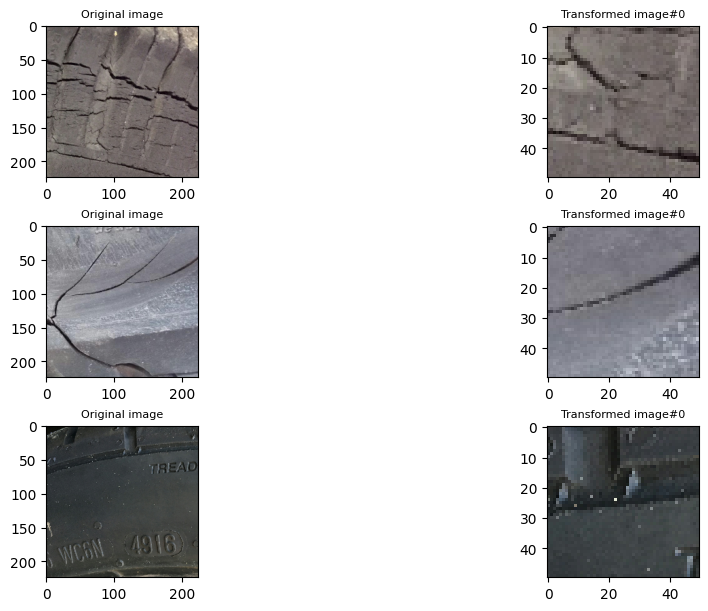

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=1, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

Since the images used are already zoomed in, this augmentation will not make much sense since there is a high loss of information involved.

## 2.4.2 RandomFlip 
This layer randomly flips images during training.

*(See Keras, 2021)*[1]

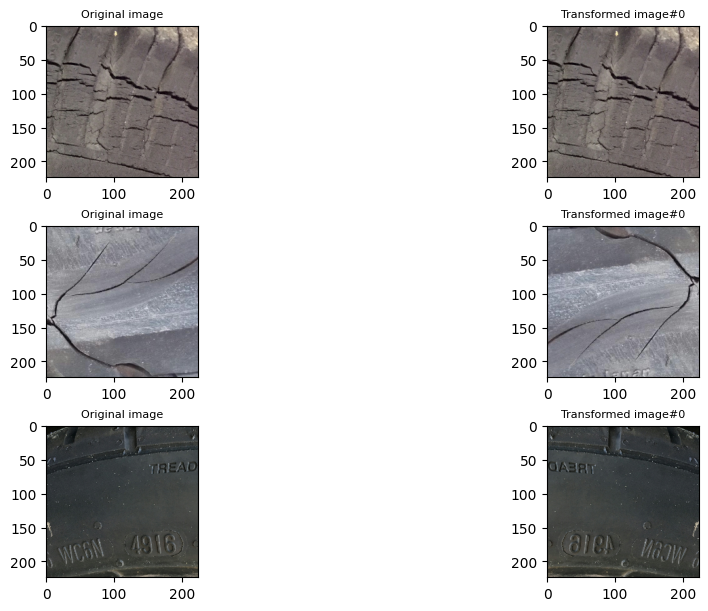

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=None,)])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This augmentation could help to introduce more diversity into the dataset and introduces different perspectives on the "cracks"\

## 2.4.3 RandomTranslation

This layer will randomly translate image, which means shifting the pixels of the input images along the horizontal and vertical axes.

*(See Keras, 2021)*[1]

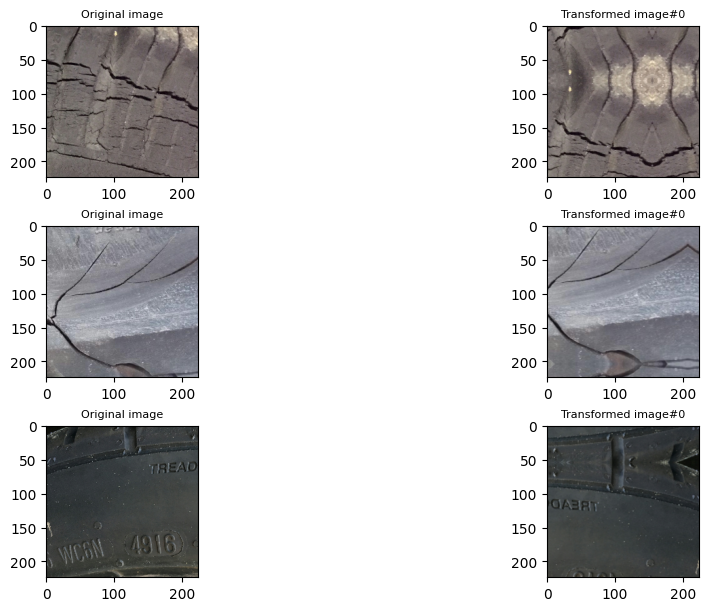

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(
    0.5,
    1,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0,)])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This augmentation layer introduces a additional variation into the data, but as the analysis has shown it also leads to a lot of lost information.

## 2.4.4 RandomRotation

This layer will randomly rotate images, introducing new perspectives on the pictures.

*(See Keras, 2021)*[1]

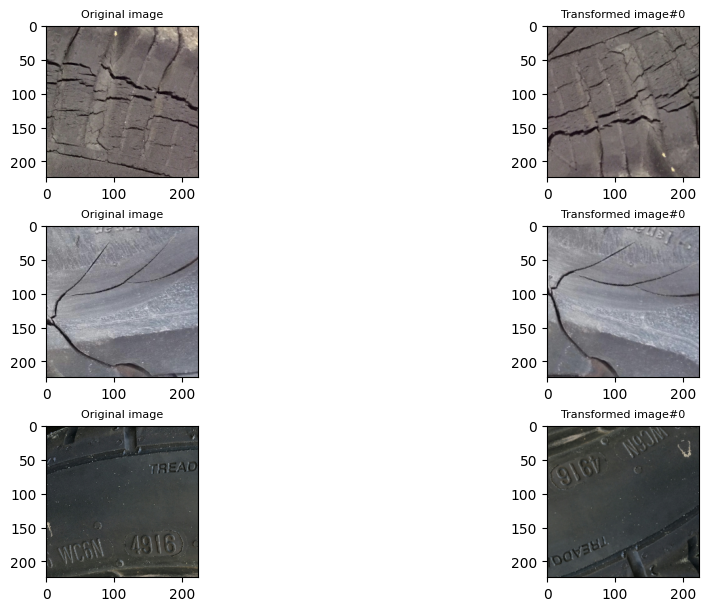

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.6,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0)
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This augmentation could help to introduce more diversity into the dataset and introduces different perspectives on the "cracks"




## 2.4.5 RandomZoom

This layer will randomly zoom images, amplifying one area of the respective image.

*(See Keras, 2021)*[1]

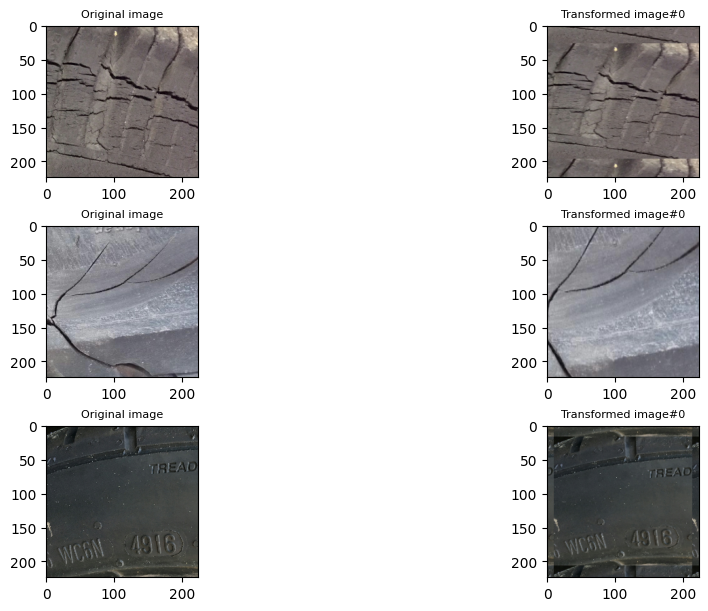

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(
    0.4,
    width_factor=0.4,
    fill_mode="wrap",
    interpolation="bilinear",
    seed=None,
    fill_value=0.0)
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This augmentation could help to introduce more diversity into the dataset and amplify some cracks. However, it also leads to a lot of lost information.

## 2.4.6 RandomHeight

A preprocessing layer which randomly varies image height during training.

*(See Keras, 2021)*[1]

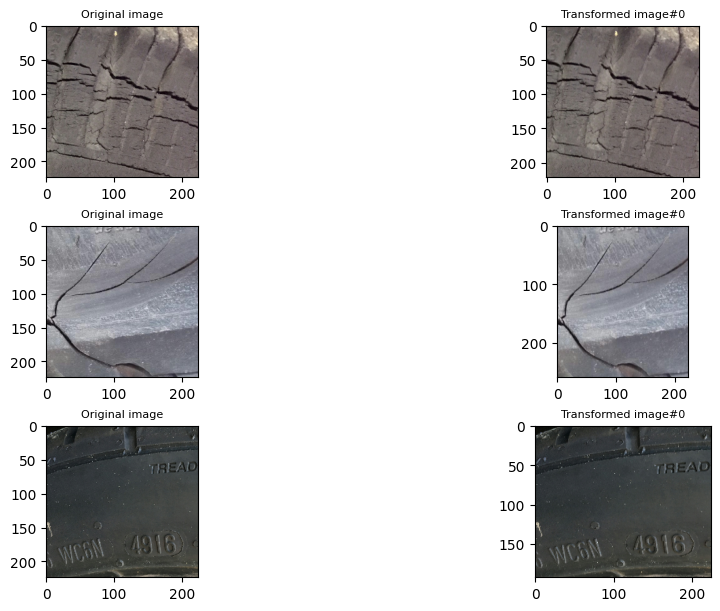

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomHeight(
    0.3, interpolation="bilinear", seed=None)
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This layer could also introduce new variations to the training data and thus be benificial to the training process

## 2.4.7 RandomWidth

A preprocessing layer which randomly varies image width during training.

*(See Keras, 2021)*[1]

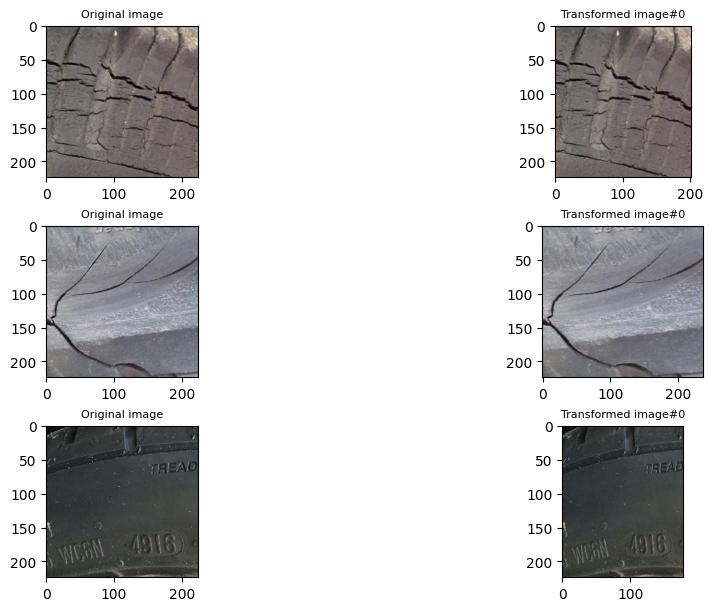

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomWidth(
    0.3, interpolation="bilinear", seed=None)
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

Similiar to the layer before, this one could also introduce new variations to the training data and thus be benificial to the training process

## 2.4.8 RandomContrast

A preprocessing layer which randomly adjusts contrast during training.

*(See Keras, 2021)*[1]

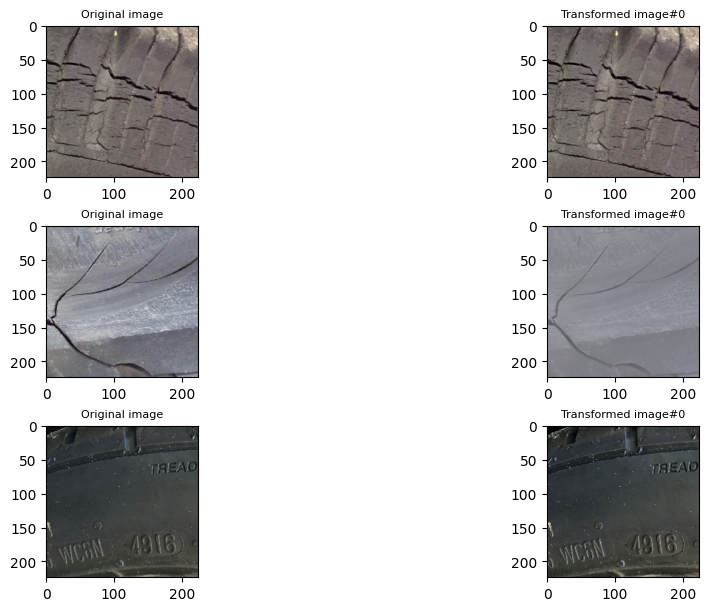

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.9, seed=None)
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

This layer can amplify the cracks on the tires and also introduces diversity into the dataset. However, since the contrast is also randomly lowered, it can lead to a loss of information

## 2.4.9 RandomBrightness

A preprocessing layer which randomly adjusts brightness  during training.

*(See Keras, 2021)*[1]

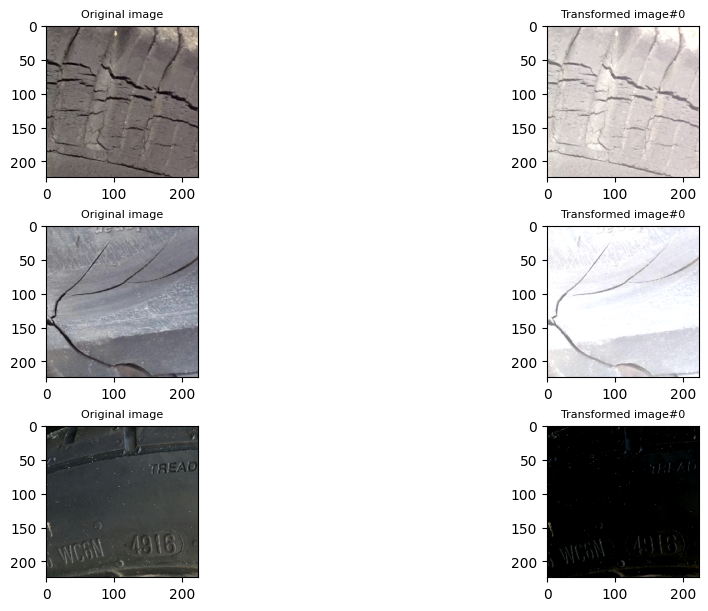

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(
    0.5, value_range=(0, 255))
])
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=data_augmentation)

Similiar to the RandomContrast layer, this layer can amplify the cracks, but as the analysis has shown it can also lead to a lot of lost information.


**Conclusion**

Options 2-4 not be applied since our dataset is composed of closed pictures of tires adding those layers would result in no gain of information, increasing our training time whitout adding value. \
1 and 5-7 may result in a loss of information too big, since our target is the detection of cracked tired, something rather small.

#2.5 Offline Augmentation

Another similar approach taken was offline data augmentation. Like the name 
implies different augmentation techniques are applied on the data and stored
in the disk, increasing our dataset. One of the main consequences of this 
technique is the memory cost, since the original dataset is not of high dimension it was considered worth to implement as it can help decrease the training time, ensure that every training is done on top of the same augmentations and allow more control over the augmentation, in the sense that it is possible to visualize a sample and ensure the quality of the techniques and parameters applied.

*See (Shorten and Khoshgoftaar, 2019)*

In [ ]:
path = '/content/drive/MyDrive/DeepLearningProject/03 Project/Data/'
main_folder, training_folder, testing_folder = "Tire Textures/", "training_data/", "testing_data/"

path_aug = '/content/drive/MyDrive/DeepLearningProject/03 Project/augmented_data/'
main_folder_aug, training_folder_aug, val_folder_aug= "Tire Textures/", "training_data/", "validation_data/"

In [ ]:
image_directory = path + main_folder + training_folder + 'cracked/'
SIZE = 224
dataset = []
my_images = os.listdir(image_directory)

for i, image_name in enumerate(my_images):
    #only processing jpg format
    #from Data Exploration it is expected that all images are on this format     
    if (image_name.split('.')[1] == 'jpg'):        
        image = io.imread(image_directory + image_name)        
        try:
          #storing a resized copy of the data set
          image = Image.fromarray(image, 'RGB') 
          image = image.resize((SIZE,SIZE)) 
          dataset.append(np.array(image))
        except:
          print(image_name)       

x = np.array(dataset)

Cracked-153.jpg


In [ ]:
X_train, X_val = train_test_split(x, test_size=0.33, random_state=42)

In [ ]:
train_x, val_x = tf.keras.utils.split_dataset(x, left_size=0.77)

In [ ]:
def custom_augmentation(np_tensor):
 
  def add_noise(img):
    #adding distortion to the images by adding random values of noise to each pixel.
    VARIABILITY = 10
    #random deviation
    deviation = VARIABILITY*random.random()
    #generation of noise to add to each pixel - value with a mean 0 and random deviation
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    #setting a limit so that the final image only has pixel values that make sense
    np.clip(img, 0., 255.)
    return img

  def random_saturation(np_tensor):
    #randomly adjusting the saturation with a factor between 0.2 and 2
    return tf.image.random_saturation(np_tensor, 0.2, 2)
  
  augmnted_tensor = random_saturation(np_tensor)
  augmnted_tensor = add_noise(augmnted_tensor)
  return np.array(augmnted_tensor)


#definition of the parameters to generate augmented data
datagen = ImageDataGenerator(        
        #rotation_range = 40,
        #zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range = (0.5, 1.5),
        preprocessing_function=custom_augmentation
        )


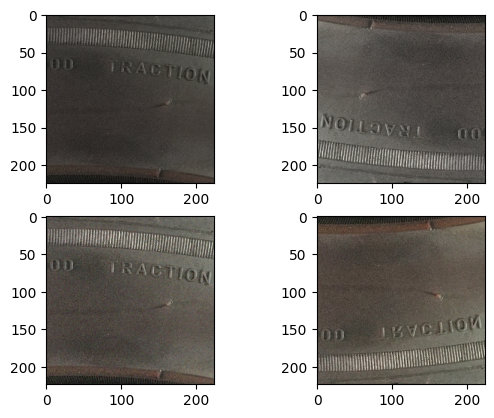

In [ ]:
#Evaluting the performance of the augmentation by using one example and acessing it works accordingly to what expected.

# Load a single image as our example
img_path = '/content/drive/MyDrive/DeepLearningProject/03 Project/Data/Tire Textures/testing_data/normal/IMG_4258.jpg'
img = tf.keras.utils.load_img(img_path, target_size=(224,224))

# Generate distorted images
images = [img]
img_arr = tf.keras.utils.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)

#flow command takes img_arr as input and applies to it the augmentation defined by the command ImageDataGenerator storing them in one batch
for batch in datagen.flow(img_arr, batch_size=1):
    images.append(tf.keras.utils.array_to_img(batch[0]))
    #generating 4 augmented pictures
    if len(images) >= 4:
        break

# Display
import matplotlib.pyplot as plt
f, xyarr = plt.subplots(2,2)
xyarr[0,0].imshow(images[0])
xyarr[0,1].imshow(images[1])
xyarr[1,0].imshow(images[2])
xyarr[1,1].imshow(images[3])
plt.show()

In [ ]:
#generating augmented data for training and validation, note that this process was repeated for subfolder normal as well

i = 0
for batch in datagen.flow(X_train, batch_size=16,
                          save_to_dir= path_aug + main_folder_aug + training_folder_aug + 'cracked/',
                          save_prefix='dr',
                          save_format='jpg'):    
    i += 1    
    if i > 50:        
        break

In [ ]:
# validation
outputFolder = path_aug + main_folder_aug + val_folder_aug + 'cracked/'

i = 0

for img in X_val:
    i +=1
    imgResized = cv2.resize(img, (224, 224))
    cv2.imwrite(os.path.join(outputFolder, str(i) + '.jpg'), imgResized)

In [ ]:
X_val

array([[[[176, 162, 152],
         [169, 155, 143],
         [161, 147, 135],
         ...,
         [ 82,  78,  72],
         [ 90,  85,  79],
         [ 75,  70,  64]],

        [[156, 142, 133],
         [155, 141, 131],
         [155, 141, 131],
         ...,
         [ 97,  92,  86],
         [ 84,  80,  74],
         [ 70,  65,  59]],

        [[160, 147, 138],
         [162, 148, 139],
         [155, 141, 132],
         ...,
         [ 98,  92,  85],
         [ 95,  91,  85],
         [ 55,  50,  44]],

        ...,

        [[ 86,  70,  73],
         [ 89,  72,  73],
         [ 89,  69,  71],
         ...,
         [ 66,  58,  55],
         [ 76,  68,  65],
         [ 60,  52,  49]],

        [[ 86,  72,  71],
         [ 89,  73,  73],
         [ 88,  70,  70],
         ...,
         [100,  91,  87],
         [ 87,  78,  74],
         [ 74,  64,  62]],

        [[ 82,  69,  68],
         [ 84,  70,  69],
         [ 87,  71,  71],
         ...,
         [104,  94,  91],
        